In [ ]:
# podaj nazwe pliku fasta np. moja_nazwa.fasta
my_file_name = "RbcL.fas"
# podaj nazwę bazy z której pobrałeś plik fasta: "uniprot" lub "ncbi"
database = "ncbi"

In [ ]:
taxo_list = ["Bacteria", "brak", "Sar", "Haptista", "Cryptophyceae", "Glaucocystophyceae", "Metazoa", "Rhodophyta", "Chlorophyta", "Marchantiophyta", "Bryophyta", "Polypodiopsida", "Gymnospermae", "Acrogymnospermae", "eudicotyledons", "Magnoliopsida", ""]

In [ ]:
import os
try:
    !pip install --upgrade pip
    !pip install biopython
    os.system("pip install ete3 pyqt5")
except ImportError:
    pass

from Bio import Entrez
Entrez.email = 'A.N.Other@gmail.com'


import pandas as pd
pd.set_option("max_colwidth", None)
pd.set_option('display.max_rows', None)
from __future__ import print_function
import numpy as np
import time
import re
import matplotlib.pyplot as plt

     |████████████████████████████████| 2.1 MB 24.6 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 28.6 MB/s eta 0:00:00


In [ ]:
class NewFasta():
  """Making new fasta file."""
  
  def __init__(self, file_name, database):
    """Initialization of the attributes needed to create a dataframe."""
    self.file_name = file_name
    self.database = database
    self.new_name = file_name[0:-6]    
  
  def preparing_fasta(self):
    """Preparation of new fast files based on fast files obtained in UniProt and NCBI"""
    # seq fasta UniProt są oddzielone "\n", a w NCBI nie, dlatego muszę usunąć entery
    with open(self.file_name, "r") as f:
      lines = f.readlines()
    with open(self.file_name, "w") as f:
      if self.database == "ncbi":
        for line in lines:
          if line != "\n":
            f.write(line)
        f.write("\n")
      if self.database == "uniprot":
        for line in lines:
          f.write(line)
        f.write("\n")

  def make_dict(self):
    """Creation of a dictionary based on data from UniProt od NCBI. seq_dict = {header:(seq), header:(seq)}"""
    self.preparing_fasta()
    file_name = open(self.file_name, "r+")
    
    count = -1
    header, seq = "", ""
    list_header = []
    seq_dict = {}

    for line in file_name:
      if line[0] == ">":
        count += 1
        seq_dict[header] = seq
        list_header.append(header)
        seq = ""
        header = line[0:-1]
      elif line[0] == "\n":
        count += 1
        seq_dict[header] = seq
        list_header.append(header)
        seq = ""
        header = line[0:-1]
      else:
        seq += str(line)
    
    print("liczba przefiltrowanych sekwencji: {}".format(count))
    file_name.close()
    return seq_dict, list_header

  def make_ncbi_df(self, df, seq_dict, list_header):
    """Creation of a dataframe based on data from UniProt. Column names: ID, Organism, Length, Sequence"""
    count = 0
    for header in list_header:
      organism = ""
      if header:
        new_row = []
        ID = header.split(" ")[0]
        if re.search("\[.*\]", header):
          organism = re.search("\[.*\]", header).group(0)
          if re.search("\w+ \w+", organism).group(0):
            organism = re.search("\w+ \w+", organism).group(0)
            count += 1
            new_row.append(count)
            new_row.append(ID[1:])
            new_row.append(organism)
            new_row.append(len(seq_dict[header][0:-1]))
            new_row.append(seq_dict[header])
            df.loc[len(df)] = new_row
          else:
            print(f"Nie zlaleziono organizmu. {header}\nnie zostanie włączony do bazy i pliku fasta.\n")
    return df

  def make_uni_df(self, df, seq_dict, list_header):
    """Creation of a dataframe based on data from NCBI. Column names: ID, Organism, Length, Sequence"""
    count = 0
    for header in list_header:
      organism = ""
      if header:
        new_row = []
        ID = header.split(" ")[0]
        if re.search("OS=\w+ \w+", header):
          organism = re.search("OS=\w+ \w+", header).group(0)
          count += 1
          new_row.append(count)
          new_row.append(ID[4:10])
          new_row.append(organism[3:])
          new_row.append(len(seq_dict[header][0:-1]))
          new_row.append(seq_dict[header])
          df.loc[len(df)] = new_row
        else:
          print(f"Nie zlaleziono organizmu. {header}\nnie zostanie włączony do bazy i pliku fasta.\n")
    return df

  def make_df(self):#, file_name, database):
    """Creating a DataFrame"""
    seq_dict, list_header = self.make_dict()
    COLUMNS = ["Index", "ID", "Organism", "Length", "Sequence"]
    df = pd.DataFrame(columns=COLUMNS)
    count = 1
    
    if self.database == "ncbi":
      df = self.make_ncbi_df(df, seq_dict, list_header)
    elif self.database == "uniprot":
      df = self.make_uni_df(df, seq_dict, list_header)
    else:
        print(f"Wybierz 'ncbi' lub 'uniprot'. Wybrano: {self.database}.\nJeżeli wybrałeś inna bazę, weź pod uwage, że program jest napisany pod kątem ww.\n")

    # replacing unusual names of organisms 
    df = df.replace('Fragaria x ananassa', 'Fragaria ananassa')
    df = df.replace('Petunia × hybrida', 'Petunia hybrida')
    df = df.replace('Cucumis x hytivus', 'Cucumis hytivus')
    df = df.replace('Climaconeis cf. scalaris', 'Climaconeis scalaris')
    df.set_index('Index')
    df.drop(['Index'], axis='columns', inplace=True)
    return df

  def new_fasta(self):
    """Making new fasta file."""
    df = self.make_df()
    path = str(self.new_name)+"_new.fasta"
    new_fasta = open(path, "w+")

    for i in range(len(df)):
      name =  df["Organism"][i]
      ID = df["ID"][i]
      seq = (df["Sequence"][i])[0:-1]
      new_fasta.write(">" + name.replace(" ", "_") + "_" + str(i) + "\n" + seq + "\n\n")
    return df
    

class FastaStats():    
  """On the basis of the DataFrame obtained from the fasta file creating seq length histograms and excel files."""
    
  def __init__(self, file_name, df):
    """Initialization of the attributes needed to create Stats."""
    self.file_name = file_name
    self.df = df

    # self.df = new_df.make_df()
  def df_hist(self, name):
    """Create sequence length histograms."""
    try:
      x_data = self.df["Length"].tolist()
      x_data = [int(x) for x in x_data]
      fig, ax = plt.subplots(figsize=(8, 6))
      num_bins = 20
      plt.xlabel('seq_length')
      plt.title(name)
      plt.hist(x_data)
      plt.show()
    except:
      print("Dataframe must contain a column named 'Length' with numeric values for the length of the sequence")

  def get_taxon(self, df):
    """Searching for taxonomies of organisms."""
    organizm_list = df['Organism'].tolist()
    organ_list = list(set(organizm_list))
    taxo_dict = {}
    other_organ = []
    for organizm in organ_list:
      handle = Entrez.esearch(db="Taxonomy", term=organizm)
      try:
        handle = Entrez.efetch(db="Taxonomy", id=Entrez.read(handle)["IdList"][0], retmode="xml")
        records = Entrez.read(handle)[0]["Lineage"]
        taxo_dict[organizm] = records
        time.sleep(2)
      except:
        other_organ.append(organizm)
        pass
    print("Searching for taxonomies of organisms complete")
    return taxo_dict, other_organ, organizm_list


  def organ_order(self, df):
    """Standardization and sorting by names of organisms."""
    list_organizmy = [re.search(r'\w+ \w+', organizm).group() for organizm in df['Organism']]
    df['Organism'] = list_organizmy
    df = df.sort_values('Organism', ascending=False)
    print("Standardization and sorting by names of organisms complete")
    return df

  def good_name(self, df):
    """Correcting the names of organisms."""
    organ_list = df['Organism'].tolist()
    organ_list2 = [re.search(r'\w+ \w+', organizm).group() for organizm in organ_list]
    df['Organism'] = organ_list2
    return df

  def taxo_df(self, taxo_list):
    """Creating a database with the names of organisms."""
    organ_list = self.df['Organism'].tolist()
    organ_list2 = [re.search(r'\w+ \w+', organizm).group() for organizm in organ_list]
    organ_common = set(organ_list2)

    COLUMNS = ["Index", "Organism", "Taxo"]
    df_numbers = pd.DataFrame(columns=COLUMNS)
    organ_list = list(organ_common)

    count = 0
    for organ in organ_list:
      to_append = [count, organ, ""]
      df_numbers.loc[len(df_numbers)] = to_append
      count += 1
    df_numbers.set_index('Index')
    df_numbers.drop(['Index'], axis='columns', inplace=True)

    taxo_dict, other_organ, organizm_list = self.get_taxon(df_numbers)

    for organ in other_organ:
      taxo_dict[organ] = "brak"

    count = 0
    df_taxo = []
    df_organ = []
    for organizm in organizm_list:
      for taxo in taxo_list:
        if taxo in taxo_dict[organizm]:
          df_taxo.append(taxo)
          df_organ.append(organizm)
          count += 1
          break

    df_taxonomy = pd.DataFrame.from_dict({'organizm': df_organ, 'taxonomy': df_taxo})
    df_taxonomy2 = df_taxonomy.replace(["Bacteria", "Sar", "Haptista", "Cryptophyceae", "Glaucocystophyceae", "Metazoa", "Rhodophyta", "Chlorophyta", "Marchantiophyta", "Bryophyta", "Polypodiopsida", "Gymnospermae", "Acrogymnospermae", "eudicotyledons", "Magnoliopsida", ""], ["Bakterie", "Sar", "Haptista", "Kryptomonady", "Archaeplastida", "Zwierzęta", "Rodofity", "Zielenice", "Wątrobowce", "Mchy", "Paprocie", "Nagonasienne", "Nagonasienne", "Dwuliścienne", "Jednoliścienne", "brak"])
    taxon_list = df_taxonomy2['taxonomy'].to_list()
    df_numbers["Taxo"] = taxon_list
      # df_numbers = df_numbers[df_numbers["Taxo"] != "Zwierzęta"]
    print(df_numbers["Taxo"].value_counts())
    df = pd.merge(self.df,df_numbers[["Taxo", "Organism"]], on="Organism")
    print("Creating a database with the names of organisms complete")
    return df

  def df_fasta(self, file_name, organizm_list):
    """Saving DataFrame in fasta format."""
    numbers = list(range(0, len(self.df)))
    self.df['index'] = numbers
    df = self.df.set_index("index")
    path = str(file_name)+".fasta"
    fasta_file = open(path, "w+")

    for i in range(len(df)):
      name =  df["Organism"][i]
      if name in organizm_list:
        ID = df["ID"][i]
        seq = (df["Sequence"][i])[0:-1]
        fasta_file.write(">" + str(ID) + " [" + name + "]" + "\n" + seq + "\n\n")


  def make_excel_files(self, df):
    name = str(self.file_name) + ".xlsx"
    df.to_excel(name)

In [ ]:
df_class = NewFasta(my_file_name, database)
df_orginal = df_class.new_fasta()
df_orginal.shape

liczba przefiltrowanych sekwencji: 323


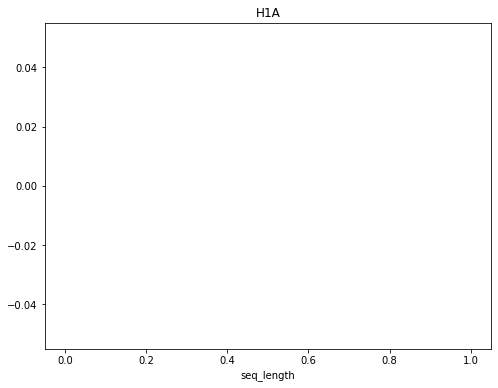

In [ ]:
short_name = my_file_name[0:-6]
new_name = short_name + "_new" + ".fasta"

plot_class = FastaStats(new_name, df_orginal)
plot_class.df_hist(short_name)

In [ ]:
df_class = FastaStats(new_name, df_orginal)
taxo_df = df_class.taxo_df(taxo_list)

df_class = NewFasta(my_file_name, database)
df_orginal = df_class.new_fasta()

df_class = FastaStats(short_name, df_orginal)
# taxo_df = df_class.taxo_df(taxo_list)
df_class.make_excel_files(taxo_df)

Searching for taxonomies of organisms complete
Zwierzęta         42
Sar                7
brak               2
Jednoliścienne     1
Bakterie           1
Dwuliścienne       1
Name: Taxo, dtype: int64
Creating a database with the names of organisms complete
liczba przefiltrowanych sekwencji: 174
